In [ ]:
import requests
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [ ]:
page = 0
data = {}
while True:
    url = f"http://steamspy.com/api.php?request=all&page={page}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching page {page}: {response.status_code}")
        break

    data_temp = response.json()
    if not data_temp:
        print("No more data found.")
        break

    print(f"Page {page} returned {len(data_temp)} games.")
    data.update(data_temp)

    page += 1
    
    time.sleep(61) # prevent rate limit

In [ ]:
with open(r'..\assets\SteamSpy\SteamSpy_raw.json', 'w') as f:
    json.dump(data, f)

In [ ]:
with open(r'..\assets\SteamSpy\SteamSpy_raw.json', 'r') as f:
    data = json.load(f)

In [ ]:
df = pd.DataFrame(data).T
df = df.convert_dtypes()
df.sample(5)

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
859860,859860,VikingJourney,Werner Schmidtberg,MTbrain iOS Development,,0,4,0,"0 .. 20,000",0,0,0,0,0,0,0,0
536510,536510,Hacker Series,exosyphen studios,exosyphen studios,,9,17,0,"0 .. 20,000",0,0,0,0,99,99,0,0
2389940,2389940,"Jump, Dodge, Die, Repeat",BigBun,BigBun,,4,0,0,"0 .. 20,000",0,0,0,0,399,399,0,0
501500,501500,Black Moon Chronicles,Cryo Interactive,Microids,,31,4,0,"0 .. 20,000",0,0,0,0,599,599,0,0
2878270,2878270,Metal: Hellsinger VR,"Lab42, The Outsiders",Funcom,,60,17,0,"0 .. 20,000",0,0,0,0,2999,2999,0,1


In [3]:
df['developer'] = df['developer'].apply(lambda x: [dev.strip() for dev in x.lower()
                                                                .replace('.', '')
                                                                .replace('inc', '')
                                                                .replace('llc', '')
                                                                .replace('ltd', '')
                                                                .split(',')
                                                    if dev.strip()])
df['publisher'] = df['publisher'].apply(lambda x: [pub.strip() for pub in x.lower()
                                                                .replace('.', '')
                                                                .replace('inc', '')
                                                                .replace('llc', '')
                                                                .replace('ltd', '')
                                                                .split(',')
                                                    if pub.strip()])
df['score_rank'] = df['score_rank'].apply(lambda x: 0 if x == '' else int(x))
df['estimate_owners_lower'] = df['owners'].apply(lambda x: int(x.replace(',', '').split(' .. ')[0]))
df['estimate_owners_upper'] = df['owners'].apply(lambda x: int(x.replace(',', '').split(' .. ')[-1]))
df.drop(columns='owners', inplace=True)
df['price'] = df['price'].astype(float)
df['initialprice'] = df['initialprice'].astype(float)
df['discount'] = df['discount'].astype(float)
df.rename(columns={'ccu':'concurrent_user'}, inplace=True)
df.sample(5)

,appid,name,developer,publisher,score_rank,positive,negative,userscore,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,concurrent_user,estimate_owners_lower,estimate_owners_upper
801900,801900,The last Baron's stunt (Anime),[sharf co],[sharf co],0,15,11,0,0,0,0,0,399.0,399.0,0.0,0,0,20000
1673130,1673130,Vainly,[ali saneei],[ali saneei],0,3,0,0,0,0,0,0,399.0,399.0,0.0,0,0,20000
1166230,1166230,1812: Napoleon Wars,[first games interactive],[first games interactive],0,45,15,0,0,0,0,0,699.0,699.0,0.0,0,0,20000
311720,311720,Sproggiwood,[freehold games],[freehold games],0,464,114,0,47,0,89,0,1499.0,1499.0,0.0,1,100000,200000
1379320,1379320,Anime Play Life: Unlimited,[redicion studio],[redicion studio],0,1,7,0,0,0,0,0,1799.0,1799.0,0.0,0,20000,50000


In [4]:
# check
print(sum(df['estimate_owners_lower'] > df['estimate_owners_upper']))
print(sum(df['developer'].apply(lambda x: len(x) == 0)))
print(sum(df['publisher'].apply(lambda x: len(x) == 0)))

0
213
98


In [5]:
df.describe().round(2)

,appid,score_rank,positive,negative,userscore,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,concurrent_user,estimate_owners_lower,estimate_owners_upper
count,69226.0,69226.00,69226.0,69226.0,69226.0,69226.0,69226.0,69226.0,69226.0,69215.00,69217.00,69217.00,69226.0,6.922600e+04,6.922600e+04
mean,1363499.9,0.06,1771.14,290.88,0.05,146.85,7.19,119.17,8.2,791.24,827.20,3.17,104.42,8.753517e+04,2.051520e+05
std,796101.23,2.50,36406.14,6953.86,1.98,3411.55,177.77,3974.85,213.72,1290.87,1317.06,14.13,5685.45,1.192729e+06,2.716178e+06
min,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000e+00,2.000000e+04
25%,710332.5,0.00,5.0,1.0,0.0,0.0,0.0,0.0,0.0,143.00,199.00,0.00,0.0,0.000000e+00,2.000000e+04
50%,1241795.0,0.00,19.0,6.0,0.0,0.0,0.0,0.0,0.0,499.00,499.00,0.00,0.0,0.000000e+00,2.000000e+04
75%,1932957.5,0.00,121.0,34.0,0.0,0.0,0.0,0.0,0.0,999.00,999.00,0.00,0.0,2.000000e+04,5.000000e+04
max,3375310.0,100.00,7462796.0,1131245.0,100.0,685129.0,20093.0,685129.0,20093.0,99900.00,99900.00,100.00,1249645.0,2.000000e+08,5.000000e+08


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69226 entries, 570 to 449420
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   appid                  69226 non-null  Int64  
 1   name                   69226 non-null  string 
 2   developer              69226 non-null  object 
 3   publisher              69226 non-null  object 
 4   score_rank             69226 non-null  int64  
 5   positive               69226 non-null  Int64  
 6   negative               69226 non-null  Int64  
 7   userscore              69226 non-null  Int64  
 8   average_forever        69226 non-null  Int64  
 9   average_2weeks         69226 non-null  Int64  
 10  median_forever         69226 non-null  Int64  
 11  median_2weeks          69226 non-null  Int64  
 12  price                  69215 non-null  float64
 13  initialprice           69217 non-null  float64
 14  discount               69217 non-null  float64
 15  conc

In [7]:
unique_counts_developer= df['developer'].explode().value_counts()
dict(unique_counts_developer)

{'choice of games': 140,
 'creobit': 126,
 'laush dmitriy sergeevich': 106,
 'koei tecmo games co': 106,
 'boogygames studios': 96,
 'sokpop collective': 94,
 'square enix': 91,
 'hosted games': 89,
 'tero lunkka': 87,
 'dnovel': 77,
 'archor wright': 66,
 'elephant games': 64,
 'sega': 60,
 'rewindapp': 59,
 'gamesforgames': 59,
 'blender games': 57,
 'valkeala software': 55,
 'magix software gmbh': 55,
 'somer games': 54,
 'do games limited': 54,
 'ripknot systems': 53,
 'epixr games ug': 52,
 'capcom co': 51,
 'blessing company': 50,
 'hede': 47,
 '橙光游戏': 46,
 'nikita "ghost_rus"': 46,
 'winged cloud': 44,
 'kairosoft co': 43,
 'feral interactive (mac)': 43,
 'william at oxford': 42,
 'milestone srl': 41,
 'idea factory': 41,
 'anamik majumdar': 41,
 'eipix entertainment': 40,
 'arc system works': 40,
 'mages': 40,
 'samet acar': 39,
 'amax interactive': 38,
 'ensenasoft': 37,
 'follow the fun': 37,
 'nihon falcom': 37,
 'g-mode': 35,
 'cyberstep': 35,
 'individual software': 35,
 '

In [8]:
unique_counts_publisher = df['publisher'].explode().value_counts()
dict(unique_counts_publisher)

{'big fish games': 357,
 '8floor': 233,
 'sega': 208,
 'conglomerate 5': 170,
 'hh-games': 163,
 'electronic arts': 158,
 'strategy first': 155,
 'kagura games': 150,
 'ubisoft': 148,
 'square enix': 147,
 'thq nordic': 147,
 'choice of games': 140,
 'sekai project': 137,
 'plug in digital': 130,
 'devolver digital': 126,
 'laush studio': 123,
 'sa industry': 120,
 'fulqrum publishing': 119,
 'ziggurat': 116,
 'slitherine': 116,
 'playism': 110,
 'bandai namco entertainment': 109,
 'playway sa': 108,
 'koei tecmo games co': 100,
 'boogygames studios': 96,
 'komodo': 96,
 'sokpop collective': 95,
 'tinybuild': 94,
 'microids': 94,
 'nacon': 94,
 'nightdive studios': 92,
 'atari': 92,
 'hosted games': 91,
 'gamera games': 91,
 '2k': 90,
 'alawar casual': 89,
 'piece of voxel': 88,
 'disney': 87,
 'daedalic entertainment': 86,
 'my way games': 83,
 'tero lunkka': 82,
 'grabthegames': 77,
 'paradox interactive': 77,
 'artifex mundi': 76,
 'pixel games uk': 75,
 'hede': 72,
 'esdigital game

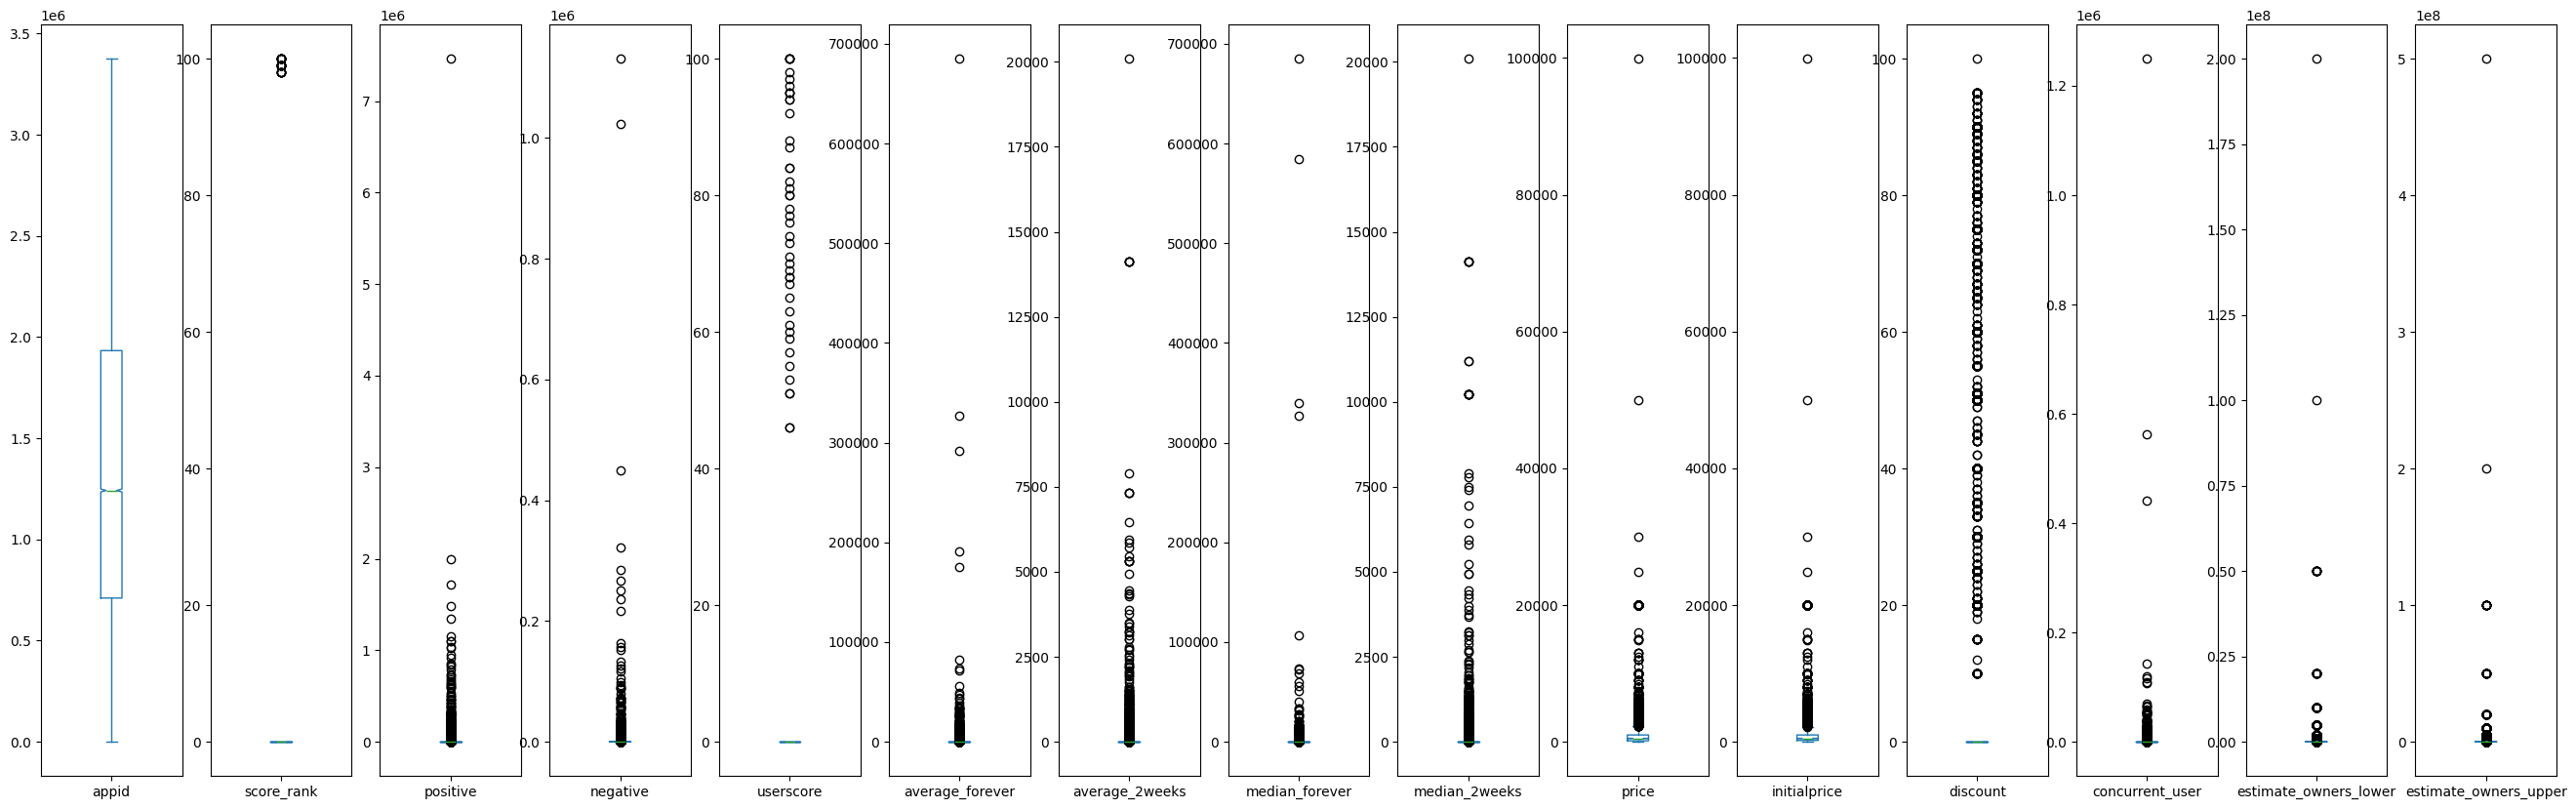

In [10]:
df.plot(kind='box', subplots=True, layout=(1, len(df.columns)), figsize=(40, 10), notch=True)
plt.show()

In [ ]:
# export df
joblib.dump(df, r'..\assets\SteamSpy\SteamSpy_clean.pkl')

['SteamSpy_clean.pkl']